In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

import snorkel
from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
import seaborn as sns

In [3]:
# read in the training data
df_train = pd.read_csv("data/training_set_seattle.csv")
df_train.head()

# read in gt.csv file
df_test = pd.read_csv('data/test_set_seattle.csv')

label_types = df_train ['label_type'].unique().tolist()
label_types

['CurbRamp',
 'Obstacle',
 'SurfaceProblem',
 'NoSidewalk',
 'NoCurbRamp',
 'Occlusion',
 'Other',
 'Signal',
 'Crosswalk']

Labeling Functions

In [70]:
# Define the label mappings for convenience
NOT_SURE = -1
WRONG = 0
CORRECT = 1

@labeling_function()
def intersection(x):
    if x["way_type"] =='residential' and (x["intersection_distance"] >= 70 or 0 < x["intersection_distance"] <= 10):
        return WRONG 
    elif x["way_type"] =='living_street' and (x["intersection_distance"] >= 70 or 0 < x["intersection_distance"] <= 10):    
        return WRONG
    else:
        return NOT_SURE

    
#check if the label is in the cluster
@labeling_function()
def clustered(x):
    if x["label_type"] =='NoSidewalk' and x["count"] <= 2:
        return WRONG
    elif x["label_type"] =='NoCurbRamp' and x["count"] <= 4:
        return WRONG 
    elif x["label_type"] =='CurbRamp' and x["count"] > 5:
        return CORRECT
    else:
        return NOT_SURE
    # return CORRECT if x['count'] >= 2 else NOT_SURE


#check if it is a severity 4 or higher
@labeling_function()
def severity(x):
    if x["label_type"] =='NoSidewalk' and x["severity"] < 3:
        return WRONG
    elif x["label_type"] =='NoCurbRamp' and x["severity"] <= 2:
        return WRONG
    elif x["label_type"] =='CurbRamp' and x["severity"] >= 4:
        return WRONG
    elif (x["label_type"] =='Obstacle' or x["label_type"] =='SurfaceProblem') and x["severity"] >= 4:
        return CORRECT
    else:
        return NOT_SURE
    return CORRECT if x["severity"] >= 4 else NOT_SURE


#check if the user zoomed in
@labeling_function()
def zoom(x):
    # x in this case is a row of the dataframe
    if x["zoom"] > 1:
        return CORRECT
    elif (x["label_type"] =='Obstacle' or x["label_type"] =='SurfaceProblem') and x["zoom"] == 1:
        return WRONG
    else:
        return NOT_SURE


#check if the user has put a tag
@labeling_function()
def tags(x):
    if x["label_type"] =='NoSidewalk' and x["tag_list"] == 1:
        return CORRECT
    elif x["label_type"] =='NoCurbRamp' and x["tag_list"] == 1:
        return CORRECT
    elif x["label_type"] =='CurbRamp' and x["tag_list"] == 1:
        return CORRECT
    else:
        return NOT_SURE
    return CORRECT if x['tag_list']  == 1 else NOT_SURE


#check if the user has put a comment
@labeling_function()
def description(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['description']  == 1 else NOT_SURE

@labeling_function()
def distance(x):
    # x in this case is a row of the dataframe
    if x["label_type"] =='NoSidewalk' and x["distance"] < 10:
        return WRONG
    elif x["label_type"] =='Obstacle' and x["distance"] > 40:
        return WRONG
    elif x["label_type"] =='SurfaceProblem' and x["distance"] > 40:
        return WRONG  
    else:
        return NOT_SURE

lfs = [
    intersection, 
    clustered,
    severity,
    zoom,
    tags,
    description,
    distance
    ]

In [33]:
applier = PandasLFApplier(lfs=lfs)
summary = pd.DataFrame(columns=['label_type', 'accuracy'])

for i in range(0,5):
    L_train = applier.apply(df=df_train[df_train['label_type'] == label_types[i]])
    X_test = applier.apply(df=df_test[df_test['label_type'] == label_types[i]])
    y_test = df_test[df_test['label_type'] == label_types[i]].verified.values

    # X_strong, X_test, y_strong, y_test = train_test_split(L_test, y_test, test_size=0.1, random_state=9)

    label_model = LabelModel(cardinality=2, verbose=True)
    label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)
    label_model_acc = label_model.score(L=X_test, Y=y_test, metrics=["precision"],tie_break_policy="random")[
    "precision"
    ]

    # majority_model = MajorityLabelVoter()
    # preds_train = majority_model.predict(L=L_train)

    # majority_acc = majority_model.score(L=X_test, Y=y_test, metrics=["accuracy"], tie_break_policy="random")[
    # "accuracy"
    # ]

    summary = summary.append({'label_type': label_types[i], 'precision': round(label_model_acc,4)}, ignore_index=True)

100%|██████████| 5333/5333 [00:00<00:00, 18040.50it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.073]
INFO:root:[100 epochs]: TRAIN:[loss=0.001]
INFO:root:[200 epochs]: TRAIN:[loss=0.000]
 43%|████▎     | 216/500 [00:00<00:00, 2159.46epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.000]
INFO:root:[400 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 2157.26epoch/s]
INFO:root:Finished Training
100%|██████████| 2909/2909 [00:00<00:00, 20337.86it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.031]
INFO:root:[100 epochs]: TRAIN:[loss=0.000]
INFO:root:[200 epochs]: TRAIN:[loss=0.000]
 44%|████▎     | 218/500 [00:00<00:00, 2179.52epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.000]
INFO:root:[400 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 2177.47epoch/s]
INFO:root:Finished Training


KeyboardInterrupt: 

All label types in one

In [71]:
applier = PandasLFApplier(lfs=lfs)
summary = pd.DataFrame(columns=['label_type', 'accuracy'])

# lr = ["constant", "linear", "exponential", "step"]

L_train = applier.apply(df=df_train)
X_test = applier.apply(df=df_test)
y_test = df_test.verified.values

# X_strong, X_test, y_strong, y_test = train_test_split(L_test, y_test, test_size=0.1, random_state=9)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, lr=0.001, log_freq=100, seed=14, lr_scheduler="linear")

label_model_acc = label_model.score(L=X_test, Y=y_test, metrics=["accuracy"],tie_break_policy="random")[
"accuracy"
]
print(f"{'Label Model accuracy:':<25} {label_model_acc * 100:.1f}%")

label_model_pre = label_model.score(L=X_test, Y=y_test, metrics=["precision"],tie_break_policy="random")[
"precision"
]
print(f"{'Label Model precision:':<25} {label_model_pre * 100:.1f}%")

100%|██████████| 16580/16580 [00:00<00:00, 17239.11it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.145]
INFO:root:[100 epochs]: TRAIN:[loss=0.020]
 35%|███▌      | 177/500 [00:00<00:00, 1765.89epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.008]
INFO:root:[300 epochs]: TRAIN:[loss=0.007]
100%|██████████| 500/500 [00:00<00:00, 1899.14epoch/s]
INFO:root:Finished Training


Label Model accuracy:     69.9%
Label Model precision:    85.1%


In [54]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
intersection,0,[0],0.039008,0.023670,0.022804
clustered,1,"[0, 1]",0.199723,0.122808,0.040768
severity,2,"[0, 1]",0.065393,0.060778,0.046434
zoom,3,"[0, 1]",0.477294,0.217933,0.067757
tags,4,[1],0.319954,0.186458,0.084202
description,5,[1],0.011181,0.009957,0.004381
distance,6,[0],0.066114,0.050206,0.044819


In [55]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

majority_acc = majority_model.score(L=X_test, Y=y_test, metrics=["accuracy"], tie_break_policy="random")[
"accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")
majority_pre = majority_model.score(L=X_test, Y=y_test, metrics=["precision"], tie_break_policy="random")[
"precision"
]
print(f"{'Majority Vote precision:':<25} {majority_pre * 100:.1f}%")



Majority Vote Accuracy:   69.8%
Majority Vote precision:  84.6%


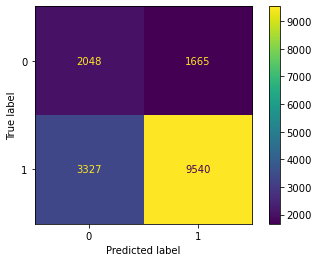

In [56]:
y_pred = label_model.predict(X_test, tie_break_policy="random")

# print("Precision:",metrics.precision_score(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

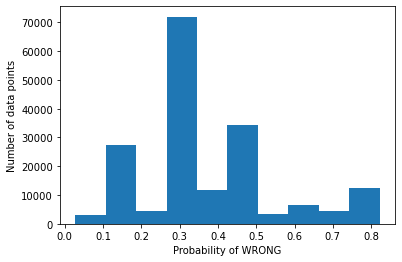

In [72]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of WRONG")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, WRONG])

In [63]:
probs_train[:, WRONG]

array([0.5       , 0.58167327, 0.27050685, ..., 0.36661709, 0.36661709,
       0.36661709])

In [73]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [68]:
# probs_train_filtered
df_train_filtered

,label_id,label_type,severity,gsv_panorama_id,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,...,geometry,clustered,count,false_positive,distance,tag_list,description,tag_count,way_type,intersection_distance
1,85057,Obstacle,2.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,38.375000,-21.875000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,POINT (-122.3318862915039 47.61780548095703),0.0,7.0,0,12.187807,0.0,1.0,0.0,-1,-1.000000
2,85059,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.500000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,POINT (-122.33183288574219 47.61751174926758),1.0,6.0,0,1.261442,0.0,0.0,0.0,tertiary,37.121175
4,85062,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,257.187500,-35.000000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,POINT (-122.33204650878906 47.617637634277344),0.0,6.0,0,2.443982,0.0,0.0,0.0,tertiary,46.324623
7,85099,CurbRamp,1.0,uEL6f2Eh9sX_PSPkQnawTg,2,57.839287,-6.669643,57.831257,3.035278,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,POINT (-122.33747100830078 47.61267852783203),0.0,2.0,0,0.238982,0.0,0.0,0.0,secondary,0.866702
8,85100,CurbRamp,1.0,uEL6f2Eh9sX_PSPkQnawTg,2,71.053574,-7.473214,57.831257,3.035278,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,...,POINT (-122.33746337890625 47.612632751464844),0.0,1.0,0,3.707810,0.0,0.0,0.0,secondary,9.616595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178958,231270,CurbRamp,1.0,R-sTl5O6sOdVPurgTWy3EQ,1,332.468750,-35.000000,215.130295,-0.157570,155af0a9-4149-4436-8aa3-7573e160036d,...,POINT (-122.26725769042969 47.540771484375),1.0,10.0,0,19.281464,0.0,0.0,0.0,residential,33.457578
178959,231285,NoSidewalk,5.0,N5MrAAtHZO2JGXUrYAYnSQ,3,0.890625,-11.656250,179.161057,-5.825714,155af0a9-4149-4436-8aa3-7573e160036d,...,POINT (-122.26344299316406 47.55229187011719),1.0,12.0,0,7.199212,0.0,0.0,0.0,-1,-1.000000
178960,231338,CurbRamp,1.0,d3oBrJ-nDtKMwlE7svc6pg,1,253.562500,-35.000000,177.959915,-0.962440,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,...,POINT (-122.28179168701172 47.563270568847656),0.0,9.0,1,14.445776,0.0,0.0,0.0,residential,152.820404
178961,231339,CurbRamp,1.0,AOIBJ12BjFanDJF1Ark05Q,1,110.312500,-35.000000,179.365723,-1.093400,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,...,POINT (-122.28165435791016 47.56346893310547),0.0,9.0,1,20.171446,0.0,0.0,0.0,residential,225.060263


In [77]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered) # Target variable

merged = pd.concat([df_train_filtered, pd.DataFrame(preds_train_filtered, index=df_train_filtered.index, columns=['LM_hard label']), pd.DataFrame(probs_train_filtered[:,WRONG], index=df_train_filtered.index, columns=['LM_soft probability of wrong'])], axis=1)
# merged = merged.rename(columns={merged.columns[0]: 'LM_hard output', merged.columns[1]: 'LM_soft probability'})

merged.to_csv('data/labelModel_outputs_Seattle.csv', index=False)